In [1]:
import gym, rec_gym
from rec_gym import env_1_args
import numpy as np

In [2]:
env_1_args

{'K': 4,
 'num_items': 100,
 'num_recommendations': 1,
 'num_users': 20,
 'embedding_dimension': 2,
 'cluster_var': 16,
 'in_cluster_var': 0.5,
 'active_user_change_proba': 0.1,
 'noise_sigma': 2,
 'user_init_sigma': 5,
 'user_drifting_kernel': <function rec_gym.envs.prim_env_v1.<lambda>(x)>,
 'user_drift_autoreg_coef': 0.1,
 'user_drift_sigma': 4,
 'user_type': 'drifting',
 'seed': 42}

In [3]:
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()

/home/anton/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/anton/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import keras
from keras.models import Sequential
from keras.layers import Dense
class DQNAgent:
    def __init__(self, name, state_shape, n_actions, epsilon=0, reuse=False):
        """A simple DQN agent"""
        with tf.variable_scope(name, reuse=reuse):
            
            network = Sequential()
            network.add(Dense(20, input_shape=state_shape))
            network.add(Dense(10))
            network.add(Dense(n_actions))
            
            self.network = network
            
            # prepare a graph for agent step
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.qvalues_t = self.get_symbolic_qvalues(self.state_t)
            
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.epsilon = epsilon

    def get_symbolic_qvalues(self, state_t):
        """takes agent's observation, returns qvalues. Both are tf Tensors"""
        #< apply your network layers here >
        #qvalues = < symbolic tensor for q-values >
        qvalues = self.network(state_t) 
        
        assert tf.is_numeric_tensor(qvalues) and qvalues.shape.ndims == 2, \
            "please return 2d tf tensor of qvalues [you got %s]" % repr(qvalues)
        assert int(qvalues.shape[1]) == n_actions
        
        return qvalues
    
    def get_qvalues(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.qvalues_t, {self.state_t: state_t})
    
    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p = [1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

Using TensorFlow backend.


In [5]:
def make_env():
    env = gym.make('prim-gym-v1')
    env.init_gym(env_1_args)
    return env

env = make_env()

state_dim = tuple([env_1_args['embedding_dimension']])
n_actions = env_1_args['num_items']

agent = DQNAgent("dqn_agent", state_dim, n_actions, epsilon=0.5)
sess.run(tf.global_variables_initializer())

(100, 2)


In [6]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        obs = env.reset()
        s = obs[1][obs[2]]
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            obs, r, done, _ = env.step(action)
            s = obs[1][obs[2]]
            reward += r
            if done: break
                
        rewards.append(reward)
    return np.mean(rewards)

In [7]:
evaluate(env, agent, n_games=1, t_max=100)

52.0

In [8]:
import random
class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
            
        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self._storage = []
        self._maxsize = size
                
    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize. 
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        
        # add data to storage
        self._storage.append(data)
        if len(self._storage) > self._maxsize:
            self._storage.pop(0)
        
    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        # <randomly generate batch_size integers to be used as indexes of samples>
        idxes = np.random.choice(range(len(self._storage)), size=batch_size)
        
        # collect <s,a,r,s',done> for each index      
        states, actions, rewards, next_states, is_done = zip(*[self._storage[i] for i in idxes])
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(is_done)


In [9]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import DataFrame
moving_average = lambda x, span=100, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(span=span, **kw).mean().values
%matplotlib inline

mean_rw_history = []
td_loss_history = []

In [10]:
def play_and_record(agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.
    
    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"
    
    :returns: return sum of rewards over time
    """
    # initial state
    s = env.reset()
    
    rewards = []
    # Play the game for n_steps as per instructions above
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s[1][s[2]]])
        action = agent.sample_actions(qvalues)[0]
        next_s, r, done, _ = env.step(action)
            
        rewards.append(r)
        exp_replay.add(s[1][s[2]], action, r, next_s[1][next_s[2]], done)
         
        if done:
            s = env.reset()
        else:
            s = next_s
               
    return np.mean(rewards)

In [11]:
target_network = DQNAgent("target_network", state_dim, n_actions)

def load_weigths_into_target_network(agent, target_network):
    """ assign target_network.weights variables to their respective agent.weights values. """
    assigns = []
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        assigns.append(tf.assign(w_target, w_agent, validate_shape=True))
    # tf.get_default_session().run(assigns)
    return assigns

copy_step=load_weigths_into_target_network(agent, target_network) 
sess.run(copy_step)

[array([[ 0.38259357,  0.43217772, -0.28282267, -0.18990332, -0.02004564,
         -0.32886153, -0.2992681 ,  0.3864112 ,  0.355268  ,  0.00216413,
          0.36116427,  0.12443745,  0.33830595, -0.14649415,  0.43234652,
          0.3729509 ,  0.09164912,  0.13445318,  0.06823772,  0.3862121 ],
        [ 0.42829597, -0.3640753 ,  0.22744197, -0.17275918, -0.31742865,
          0.44093078, -0.5069583 , -0.2061829 , -0.11808419,  0.09453124,
          0.33629125,  0.31069338, -0.32201248,  0.01523614,  0.47303104,
          0.37137794, -0.3448313 ,  0.23420328, -0.10129824,  0.38527477]],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], dtype=float32),
 array([[ 0.148875  ,  0.16661316,  0.00123769,  0.257434  , -0.03158855,
         -0.03011969, -0.21902078,  0.14072675,  0.34148848,  0.11572087],
        [-0.17134184,  0.1809144 ,  0.20719564,  0.36962998, -0.28807884,
         -0.11009145,  0.03632575, -0.32835093

In [12]:
# placeholders that will be fed with exp_replay.sample(batch_size)
obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
actions_ph = tf.placeholder(tf.int32, shape=[None])
rewards_ph = tf.placeholder(tf.float32, shape=[None])
next_obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
is_done_ph = tf.placeholder(tf.float32, shape=[None])

is_not_done = 1 - is_done_ph
gamma = 0.99

current_qvalues = agent.get_symbolic_qvalues(obs_ph)
current_action_qvalues = tf.reduce_sum(tf.one_hot(actions_ph, n_actions) * current_qvalues, axis=1)

next_qvalues_target = target_network.get_symbolic_qvalues(next_obs_ph)
next_state_values_target = tf.reduce_max(next_qvalues_target, axis=1)
reference_qvalues = rewards_ph + gamma * next_state_values_target

# Define loss function for sgd.
td_loss = (current_action_qvalues - reference_qvalues) ** 2
td_loss = tf.reduce_mean(td_loss)

train_step = tf.train.AdamOptimizer(1e-3).minimize(td_loss, var_list=agent.weights)

In [13]:
sess.run(tf.global_variables_initializer())

In [14]:
exp_replay = ReplayBuffer(10**3)
play_and_record(agent, env, exp_replay, n_steps=1000)

def sample_batch(exp_replay, batch_size):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    return {
        obs_ph:obs_batch, actions_ph:act_batch, rewards_ph:reward_batch, 
        next_obs_ph:next_obs_batch, is_done_ph:is_done_batch
    }

buffer size = 1000, epsilon = 0.01000


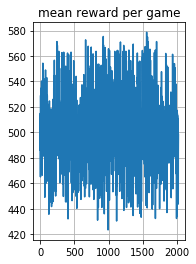

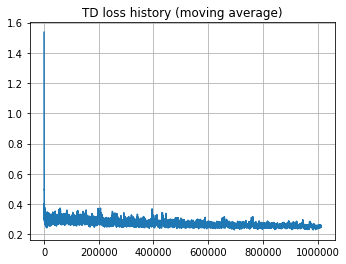


100%|██████████| 1000000/1000000 [5:06:12<00:00, 54.43it/s]

In [17]:
for i in trange(10**6):
    
    # play
    play_and_record(agent, env, exp_replay, 10)
    
    # train
    _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=64))
    td_loss_history.append(loss_t)
    
    # adjust agent parameters
    if i % 500 == 0:
        #load_weigths_into_target_network(agent, target_network)
        #calling 'load_weights_into_target_network' repeatedly cause creating tf copy operator
        #again and again, which bloat memory consumption along training step
        #create'copy_step' once 
        sess.run(copy_step)
        agent.epsilon = max(agent.epsilon * 0.99, 0.01)
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3, t_max=1000))
    
    if i % 100 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_t)
        plt.figure(figsize=[12, 4])
        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(moving_average(np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()
        plt.show()

# Video

In [18]:
agent.epsilon = 0

In [20]:
#record sessions
import gym.wrappers
env_monitor = gym.wrappers.Monitor(make_env(),directory="videos",force=True)
evaluate(env_monitor, agent, n_games=1, t_max=1000) 
env_monitor.close()

(100, 2)


In [21]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))